# Data Smoothing

### Imports

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
plt.style.use('dashboard.mplstyle')
from prepare import PrepareData
data = PrepareData(download_new=False).run()

### Smoothing California Data



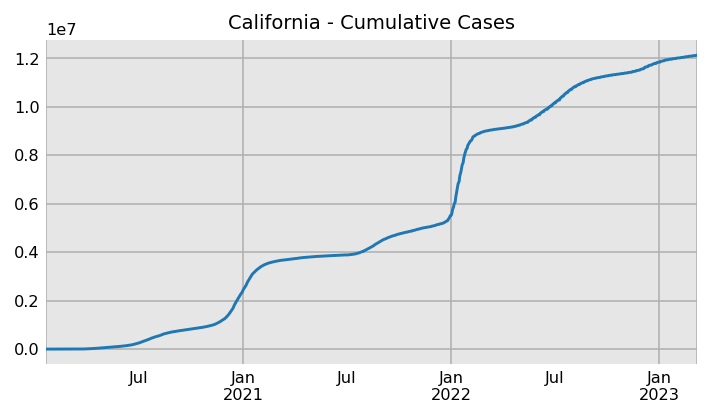

In [20]:
usa_cases = data['usa_cases']
californiac = usa_cases['California']
californiac.plot(kind='line', title="California - Cumulative Cases");

In [21]:
californiac_daily = californiac.diff()
californiac_daily.head()

2020-01-22    NaN
2020-01-23    0.0
2020-01-24    0.0
2020-01-25    0.0
2020-01-26    2.0
Name: California, dtype: float64

In [22]:
last_zero_date = californiac[californiac == 0].index[-1]
last_zero_date

Timestamp('2020-01-25 00:00:00')

In [23]:
californiac = californiac.loc[last_zero_date:]
californiac.head()

2020-01-25    0
2020-01-26    2
2020-01-27    2
2020-01-28    2
2020-01-29    2
Name: California, dtype: int64

In [24]:
californiac_daily = californiac.diff().dropna().astype('int')
californiac_daily.head()

2020-01-26    2
2020-01-27    0
2020-01-28    0
2020-01-29    0
2020-01-30    0
Name: California, dtype: int64

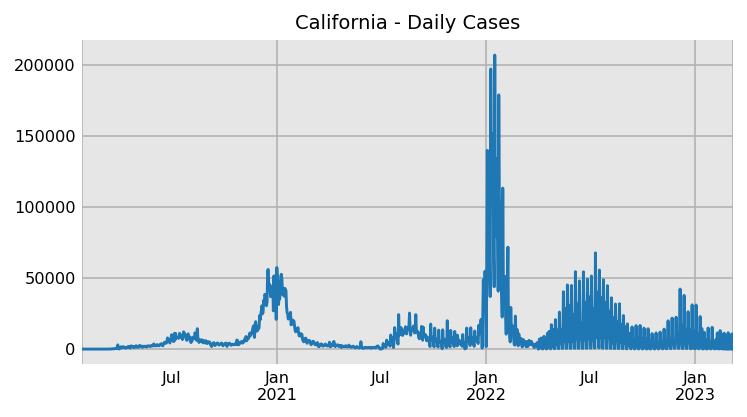

In [25]:
californiac_daily.plot(kind='line', title="California - Daily Cases");

### Seasonality

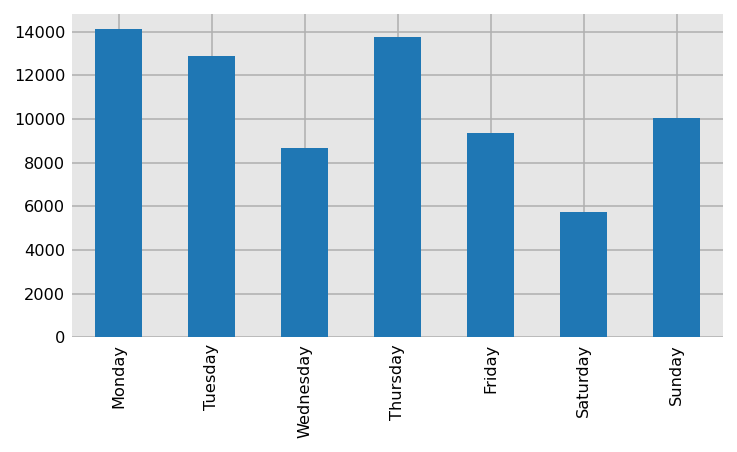

In [26]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#texasc_daily.groupby(lambda xcx: x.day_name()).mean().loc[days].plot(kind='bar');
californiac_daily.groupby(lambda xcx: xcx.day_name()).mean().loc[days].plot(kind='bar');


## LOWESS

In [9]:
from statsmodels.nonparametric.smoothers_lowess import lowess
y = californiac_daily
x = y.index
frac = 20 / len(x)
y_lowess = lowess(y, x, frac=frac, is_sorted=True, return_sorted=False)
y_lowess[-10:].round()

array([401., 369., 338., 309., 284., 259., 232., 203., 172., 137.])

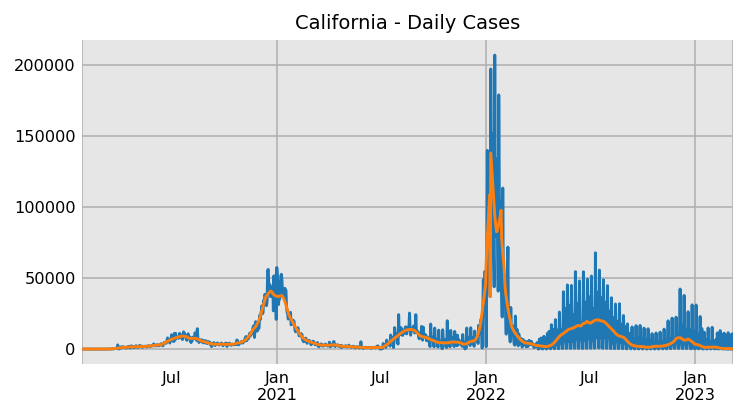

In [10]:
s_lowess = pd.Series(data=y_lowess, index=x)
californiac_daily.plot(title="California - Daily Cases", label='original')
s_lowess.plot();

## Smoothed Cumalitive Total: 


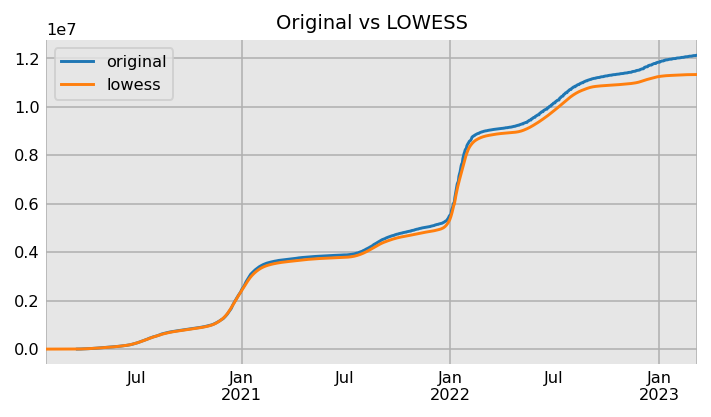

In [11]:
californiac.loc['2020-03-20':].plot(kind='line', label='original');
s_lowess_cumulative = s_lowess.cumsum().round(0).astype('int')
ax = s_lowess_cumulative.plot(label='lowess', title='Original vs LOWESS')
ax.legend();

### Aligning the Cumulative Total to the Actual


In [12]:
# actual
last_actual = californiac.values[-1]
last_actual

12129699

In [13]:
# smoothed
last_smoothed = s_lowess_cumulative.values[-1]
last_smoothed

11327964

To align the two series, we'll multiply the smoothed values by the ratio of their last values. The new last smoothed cumulative value is output to verify it is equal to the previous actual value.

In [14]:
s_lowess_cumulative = s_lowess_cumulative * last_actual / last_smoothed
s_lowess_cumulative = s_lowess_cumulative.round(0).astype('int')
s_lowess_cumulative.values[-1]

12129699

### LOWESS Method for Smoothing 

In [27]:
def smooth(s, n):
    """
    Smooths the data series using LOWESS.

    Parameters
    ----------
    s : Series
        Time series data.
    n : int
        Number of points for LOWESS.

    Returns
    -------
    Series
    """
    if s.values[0] == 0:
        # Filter the data if the first value is 0
        last_zero_date = s[s == 0].index[-1]
        s = s.loc[last_zero_date:]
        s_daily = s.diff().dropna()
    else:
        # If first value not 0, use it to fill in the
        # first missing value
        s_daily = s.diff().fillna(s.iloc[0])

    # Don't smooth data with less than 15 values
    if len(s_daily) < 15:
        return s

    y = s_daily.values
    frac = n / len(y)
    x = np.arange(len(y))
    y_pred = lowess(y, x, frac=frac, is_sorted=True, return_sorted=False)
    s_pred = pd.Series(y_pred, index=s_daily.index).clip(0)
    s_pred_cumulative = s_pred.cumsum()
    last_actual = s.values[-1]
    last_smoothed = s_pred_cumulative.values[-1]
    s_pred_cumulative *= last_actual / last_smoothed
    return s_pred_cumulative


In [1]:
from functions import smooth
smoothed = smooth(californiac, 20)
californiac.plot(label='Actual')
smoothed.plot(title='California Original vs Smoothed', label='Smoothed').legend();

NameError: name 'californiac' is not defined